# Fastai
Now I will use fastai library to do the rest of the work. Maybe implement own Datablock API.
The idea is to implement the new things under fastai so glue both fastai + pytorch... 

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
from fastai.basics import *
from fastai.callbacks import *
import numpy as np
import pandas as pd

In [3]:
from uti.get_Mnist import *

In [4]:
x_train,y_train,x_valid,y_valid = get_data()

/home/jupyter/.fastai/data/mnist.pkl.gz


In [5]:
x_train.shape,y_train.shape

(torch.Size([50000, 784]), torch.Size([50000]))

In [6]:
x_train.mean(),x_train.std()

(tensor(0.1304), tensor(0.3073))

In [7]:
def normalize_input(train,valid):
    m = train.mean()
    s = train.std()
    return (train - m) / s, (valid - m) / s

In [8]:
x_train, x_valid = normalize_input(x_train,x_valid)
x_train.mean(),x_train.std()

(tensor(0.0001), tensor(1.))

Finish normalizing data to have mean 0 and std 1

Text(0.5,1,'tensor(5)')

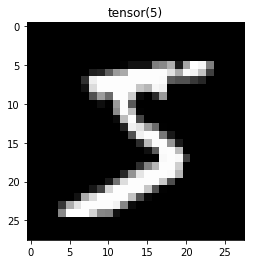

In [9]:
plt.imshow(x_train[0].view(28,28),cmap='gray')
plt.title(s = str(y_train[0]))

# Prepare datablock API

In [10]:
train_ds = TensorDataset(x_train,y_train)
valid_ds = TensorDataset(x_valid,y_valid)

In [11]:
train_dl = DataLoader(
    dataset=train_ds,
    batch_size=64,
    shuffle=True,
    num_workers=2
)
valid_dl = DataLoader(
    dataset=valid_ds,
    batch_size=128,
    num_workers=2
)

In [12]:
data = DataBunch(train_dl,valid_dl)
data.c = 10

# Prepare Model

In [13]:
def conv2d(ni,nf,ks=3,stride=2):
    return nn.Sequential(nn.Conv2d(ni,nf,ks,padding=ks//2,stride=stride),nn.ReLU())

def flatten(x):
    return x.view(x.shape[0],-1)

class Lambda(nn.Module):
    def __init__(self,func): 
        super().__init__()
        self.func = func
        
    def forward(self,xb): return self.func(xb)

In [36]:
def get_model():
    model = nn.Sequential(
        #Lambda(lambda x: x.view(-1,1,28,28).float()),
        conv2d(1,8),
        conv2d(8,16),
        conv2d(16,32),
        conv2d(32,32),
        nn.AdaptiveAvgPool2d(1),
        Lambda(flatten),
        nn.Linear(32,10),
    )
    return model

In [15]:
class BatchTransFormXCallback(Callback):
    _order = 2
    def __init__(self,tfm):
        #super().__init__(learn)
        self.tfm = tfm
    
    def on_batch_begin(self,**kwargs):
        xb = self.tfm(kwargs['last_input'])
        return {'last_input': xb.float()}

In [21]:
def get_learner(model):
    opt_func = optim.SGD
    loss_func = nn.CrossEntropyLoss()
    return Learner(data,model.cuda(),opt_func=opt_func,loss_func=loss_func,metrics=accuracy)

In [28]:
learn = get_learner(model)

In [29]:
cb = BatchTransFormXCallback(lambda x: x.view(-1,1,28,28))

In [30]:
learn.callbacks.append(cb)

In [31]:
learn.fit(3,lr=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.263892,0.267916,0.921700,00:03
1,0.203150,0.171511,0.952200,00:03
2,0.180887,0.160987,0.951400,00:03


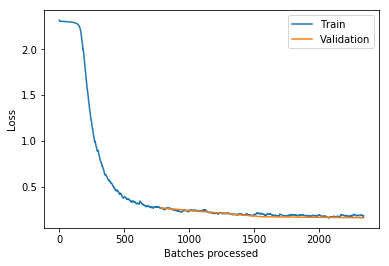

In [32]:
learn.recorder.plot_losses()

# Apply Kaiming init

In [38]:
def init_model(model):
    for layer in model:
        if isinstance(layer,nn.Sequential):
            nn.init.kaiming_normal_(layer[0].weight)
            layer[0].bias.detach().zero_()

In [57]:
model = get_model()
learn = get_learner(model)
cb = BatchTransFormXCallback(lambda x: x.view(-1,1,28,28))
learn.callbacks.append(cb)
learn.callback_fns.append(ActivationStats)

In [58]:
init_model(learn.model)

In [59]:
learn.model[0][0].bias

Parameter containing:
tensor([0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0', requires_grad=True)

In [60]:
learn.fit(3,lr=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.239890,0.199682,0.943100,00:04
1,0.179770,0.153804,0.959100,00:04
2,0.160358,0.140254,0.959900,00:04


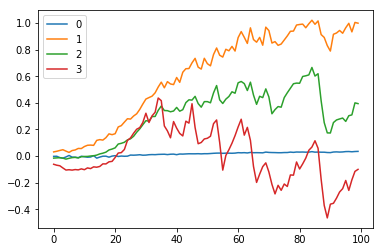

In [61]:
means = learn.activation_stats.stats[0]
for i in range(4):
    plt.plot(means[i][:100])
plt.legend(range(4))

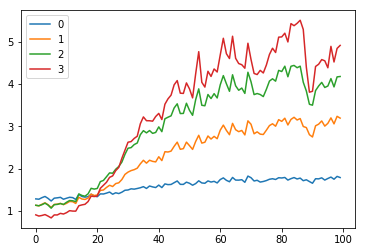

In [62]:
std = learn.activation_stats.stats[1]
for i in range(4):
    plt.plot(std[i][:100])
plt.legend(range(4))

# Get a SubRelu to make next layer activations 0 mean and 1 std

In [63]:
class SubRelu(nn.Module):
    def __init__(self,sub=0.4):
        super().__init__()
        self.sub = sub
    
    def forward(self,xb):
        xb = F.relu(xb)
        xb.sub_(self.sub)
        return xb

def subConv2d(ni,nf,ks=3,stride=2):
    return nn.Sequential(nn.Conv2d(ni,nf,ks,padding=ks//2,stride=stride),SubRelu())

def get_subRelu_model():
    model = nn.Sequential(
        #Lambda(lambda x: x.view(-1,1,28,28).float()),
        subConv2d(1,8),
        subConv2d(8,16),
        subConv2d(16,32),
        subConv2d(32,32),
        nn.AdaptiveAvgPool2d(1),
        Lambda(flatten),
        nn.Linear(32,10),
    )
    return model

In [79]:
new_model = get_subRelu_model()
learn_sub = get_learner(new_model)
cb = BatchTransFormXCallback(tfm=lambda x: x.view(-1,1,28,28))
learn_sub.callbacks.append(cb)
learn_sub.callback_fns.append(ActivationStats)

In [80]:
init_model(learn_sub.model)

In [81]:
learn_sub.model

Sequential(
  (0): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): SubRelu()
  )
  (1): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): SubRelu()
  )
  (2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): SubRelu()
  )
  (3): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): SubRelu()
  )
  (4): AdaptiveAvgPool2d(output_size=1)
  (5): Lambda()
  (6): Linear(in_features=32, out_features=10, bias=True)
)

To enable cos sched with discriminative lr, we need to split the model. If we don't split the model, fit_one_cycle with slice(start,end,step) lr will throw listify error

# This will throw error

In [82]:
learn_sub.fit_one_cycle(1,slice(1e-1,4e-4))

ZeroDivisionError: division by zero

# Cut Model using Split

Let's pretend we are doing transfer learning and cutting for our own head. We will cut before flatten so we have CNN, Linear

In [83]:
learn_sub.split(lambda m: m[4])

Learner(data=DataBunch;

Train: <torch.utils.data.dataset.TensorDataset object at 0x7f4489abb518>;

Valid: <torch.utils.data.dataset.TensorDataset object at 0x7f4489abb8d0>;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): SubRelu()
  )
  (1): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): SubRelu()
  )
  (2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): SubRelu()
  )
  (3): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): SubRelu()
  )
  (4): AdaptiveAvgPool2d(output_size=1)
  (5): Lambda()
  (6): Linear(in_features=32, out_features=10, bias=True)
), opt_func=<class 'torch.optim.sgd.SGD'>, loss_func=CrossEntropyLoss(), metrics=[<function accuracy at 0x7f448a79ed08>], true_wd=True, bn_wd=True, wd=0.01, train_bn=True, path=PosixPath('.'), model_dir='models', cal

In [84]:
learn_sub.layer_groups

[Sequential(
   (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
   (1): SubRelu()
   (2): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
   (3): SubRelu()
   (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
   (5): SubRelu()
   (6): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
   (7): SubRelu()
 ), Sequential(
   (0): AdaptiveAvgPool2d(output_size=1)
   (1): Lambda()
   (2): Linear(in_features=32, out_features=10, bias=True)
 )]

Now we can apply different lr on different groups

In [85]:
learn_sub.fit_one_cycle(8,slice(1e-2,4e-1),pct_start=0.5)

epoch,train_loss,valid_loss,accuracy,time
0,0.275208,0.221999,0.934600,00:04
1,0.151158,0.136418,0.959500,00:04
2,0.115866,0.111970,0.967000,00:04
3,0.101995,0.093741,0.972100,00:04
4,0.085266,0.086239,0.974200,00:04
5,0.072344,0.075149,0.977100,00:04
6,0.046936,0.062006,0.983500,00:04
7,0.037676,0.055213,0.984300,00:04


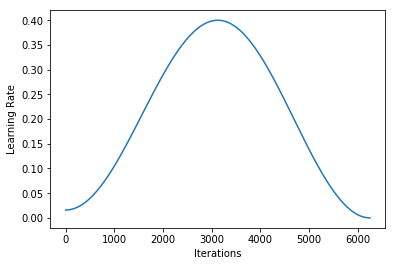

In [86]:
learn_sub.recorder.plot_lr()

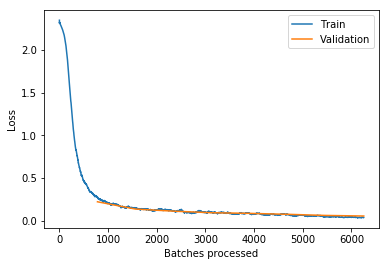

In [87]:
learn_sub.recorder.plot_losses()

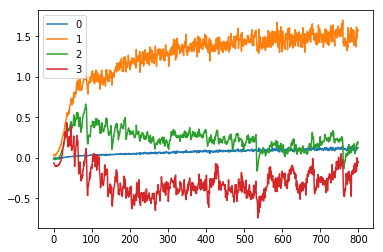

In [88]:
means = learn.activation_stats.stats[0]
for i in range(4):
    plt.plot(means[i][:800])
plt.legend(range(4))

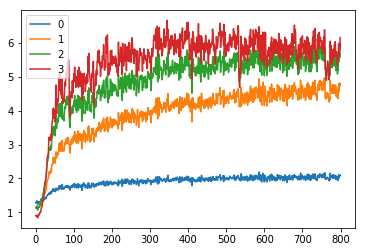

In [89]:
std = learn.activation_stats.stats[1]
for i in range(4):
    plt.plot(std[i][:800])
plt.legend(range(4))

# Fin

Conculsion:

1. Apply Fastai on top of pytorch, skipped using datablock API
2. Create own model, without using transfer learning
3. Callback to reshape (can extend to use other libraries in callback, such as opencv for data argumentation, or copy and paste fast ai data argumentation and create your own callback to apply)
4. Split the model, this way we can take advantage of the fastai discriminative learning rate
5. Cos sched with pct_starts to have different cosine shape
6. Activation states, pre-defined fastai hook to show activations.